## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T

from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model, GIN_COPY
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test, plot_results

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the corresponsing csv, store the dataset to the DB, preprocess it, and get it as a pytorch graph object

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title"],
    list_features=[],
    fastRP_features=["fastRP_genres", "fastRP_keywords", "fastRP_cast", "fastRP_crew"],
    numeric_features=["vote_average", "vote_count"],
)
# path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

Processing...


Encoding title...


Batches: 100%|██████████| 284/284 [00:07<00:00, 37.92it/s]


Encoding fastRP_genres...
Encoding fastRP_keywords...
Encoding fastRP_cast...
Encoding fastRP_crew...
Encoding ['vote_average', 'vote_count']...
[torch.Size([9067, 384]), torch.Size([9067, 32]), torch.Size([9067, 32]), torch.Size([9067, 32]), torch.Size([9067, 32]), torch.Size([9067, 2])]


Done!


#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [5]:
[v.shape for v in train_data.x_dict.values()]

[torch.Size([9067, 514]), torch.Size([671, 671])]

#### Define and train-test the model

In [6]:
model = Model(
    data,
    layer_name="GIN",
    encoder_num_layers=6,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=8,
    hidden_channels=16,
    out_channels=16,
).to(device)

# model = GIN_COPY(dim_h=32)

losses = train_test(
    model=model,
    epochs=500,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    logging_step=10,
    lr=0.012,
)

/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


x: <class 'tuple'> 2 torch.Size([671, 671]) torch.Size([9067, 514])
edge_index: <class 'torch.Tensor'> torch.Size([2, 79835])


AssertionError: 

#### Visualize

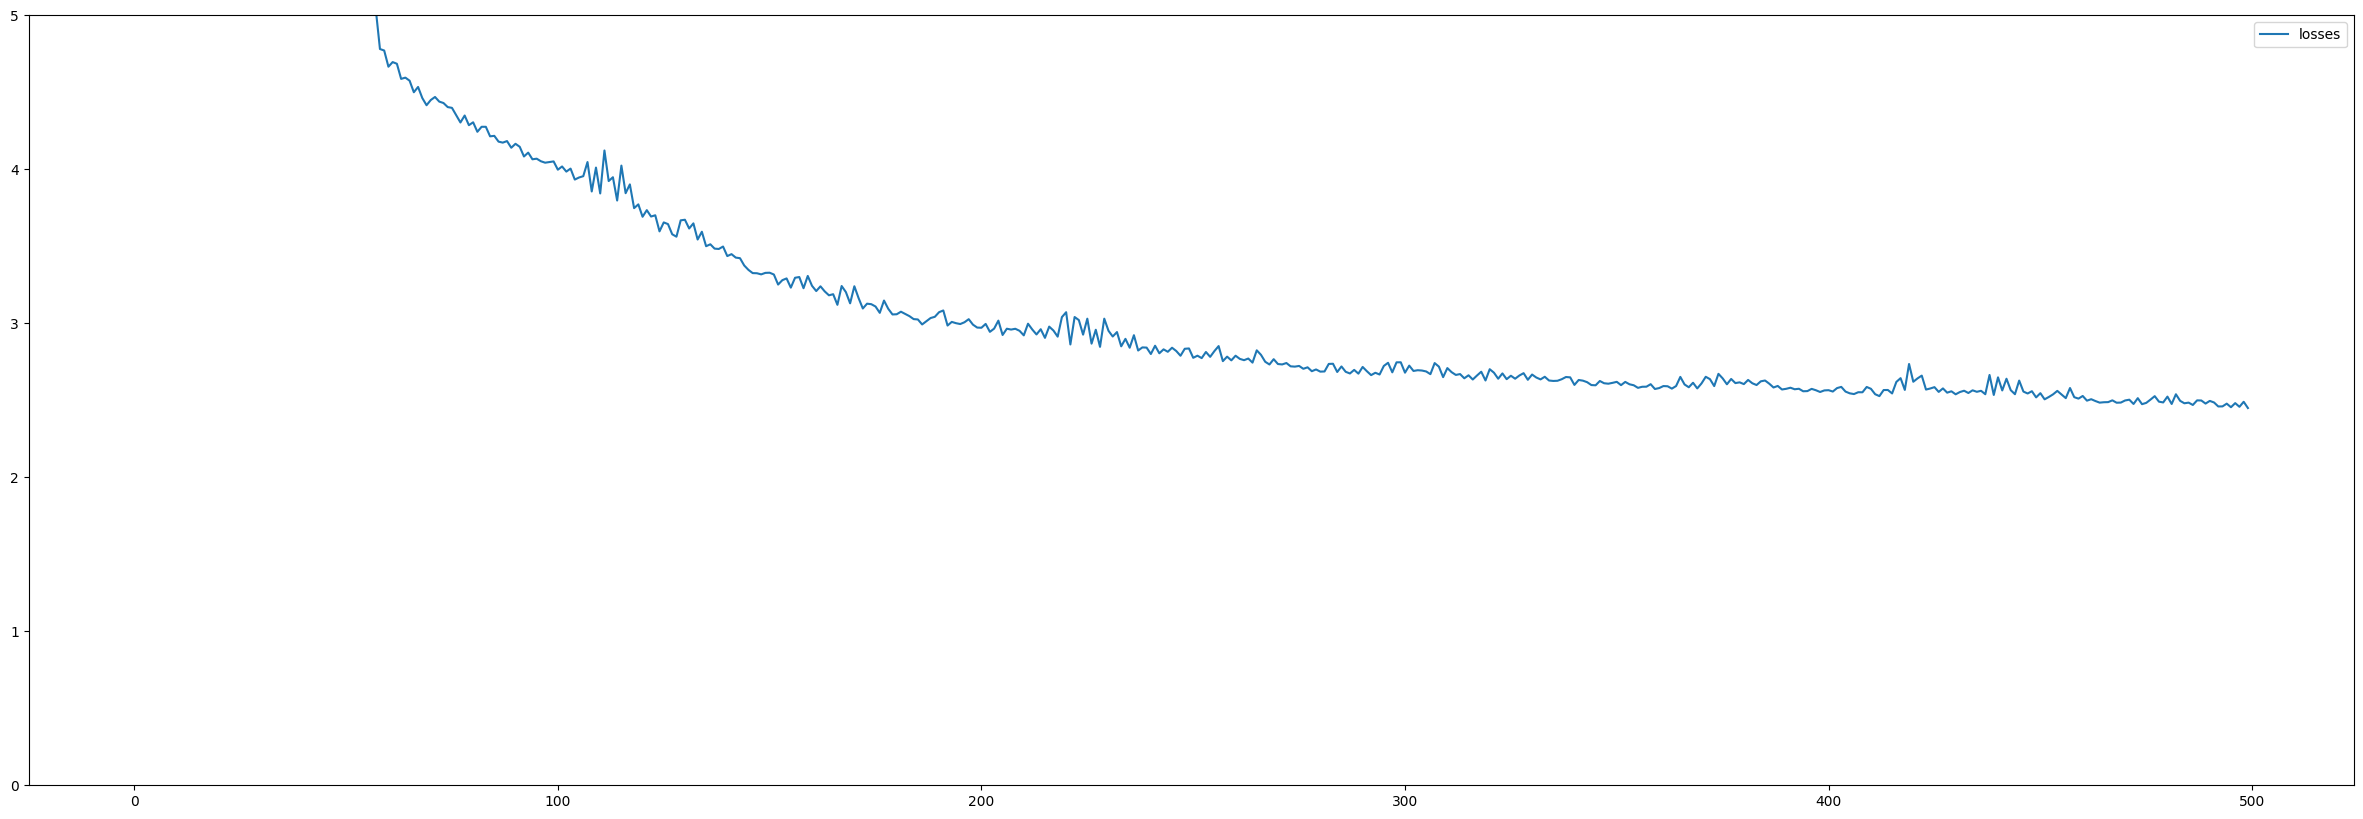

In [ ]:
plot_loss({ "losses": losses }, ylim=5)